# Script for generating trait + population graphs
Plots each species in one simulation on the same graph (for comparison between species)
Prints each trait from all simulations next to each other (for comparison between different simulations)

In [1]:
export = False

In [2]:
# basic imports and reading of file
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from pathlib import Path
import glob
import time
import networkx as nx
import json

In [3]:
# load logs
traits = []
fcms = []
dataframes = []
fcmJsons = []

subFolders = glob.glob("Logs/*/")
for sub in subFolders:
    traits = traits + glob.glob(sub +"*.txt")
    fcms = fcms + glob.glob(sub + "*.json")
for file in traits:
    dataframes.append((pd.read_csv(file), file.split('\\')[1]))
for file in fcms:
    with open(file, 'r') as f:
        fcm = json.load(f)
    fcmJsons.append((fcm, file.split('\\')[1], file.split('\\')[2].split('.')[0]))

In [4]:
# see what species and traits exist
species = set()
traits = set()
for df in dataframes:
    for col in df[0].columns:
        species.add(col.split('-')[0])
        traits.add(col.split('-')[1])

In [5]:
# make export folder
folder="Graphs/" + time.strftime("%m-%d--%H-%M-%S")
Path(folder).mkdir(parents=True, exist_ok=True)

(False, <networkx.classes.graph.Graph object at 0x000001FDC4370E88>)


NetworkXException: G is not planar.

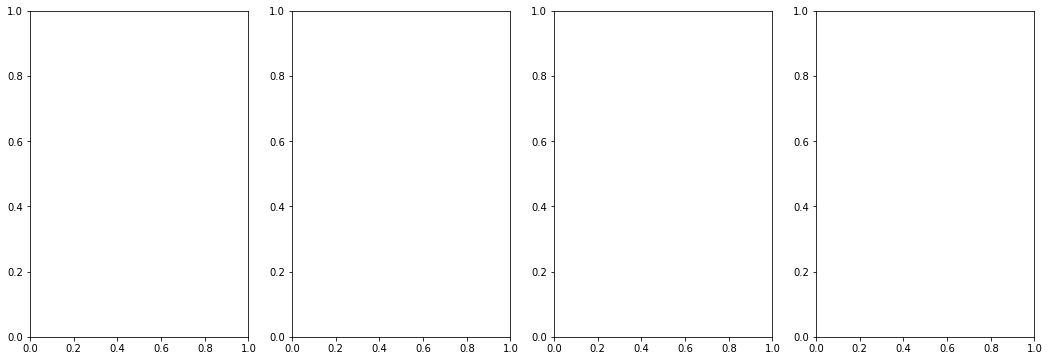

In [8]:
# plot fcm
for s in species:
    
    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,6))
    #fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for fcm in fcmJsons:

        if fcm[2] == s:
            G = nx.DiGraph(directed=True)
            for entry in fcm[0]['weights']:
                G.add_weighted_edges_from([(entry['from'], entry['to'], entry['weight'])])

            edge_labels=dict([((u,v,),d['weight'])
                             for u,v,d in G.edges(data=True)])

            print(nx.check_planarity(G, True))
            pos=nx.planar_layout(G)
            nx.draw_networkx(G, pos, arrows=True, arrowsize=20, with_labels=True, node_size=600, font_color='black', ax = axes[counter], title = fcm[1])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax = axes[counter], title = fcm[1])
            axes[counter].set_xticklabels([])
            axes[counter].set_yticklabels([])
            axes[counter].set_title(fcm[1])
            counter += 1
    fig.suptitle(s, y = 0.97, size = 20)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.87)
    if export:
        fig.savefig(folder + "/" + s)
        

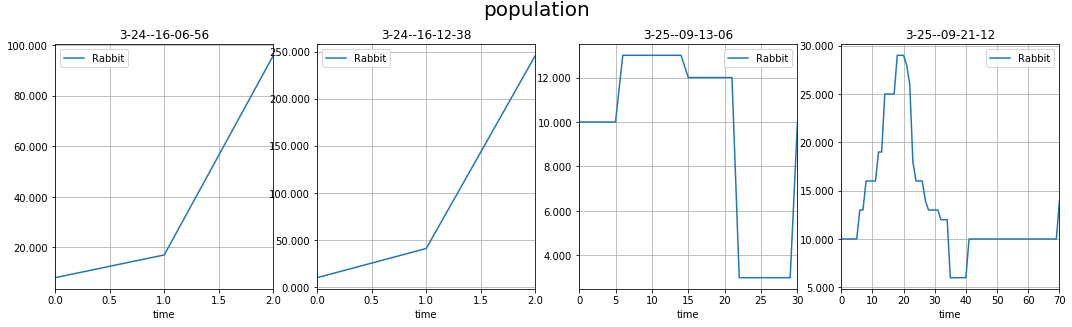

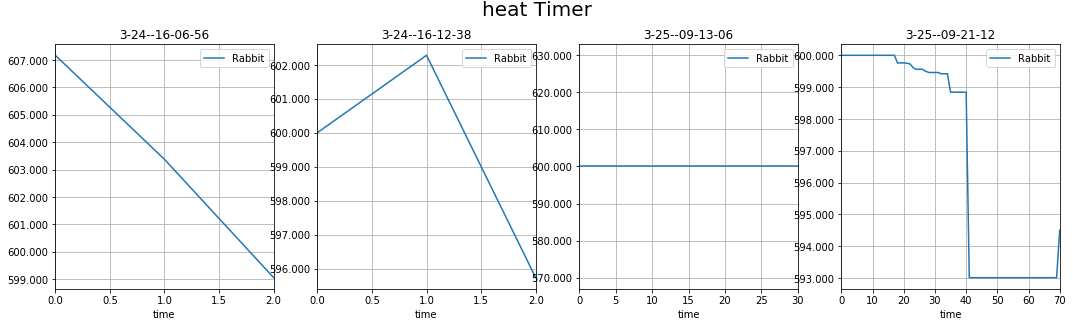

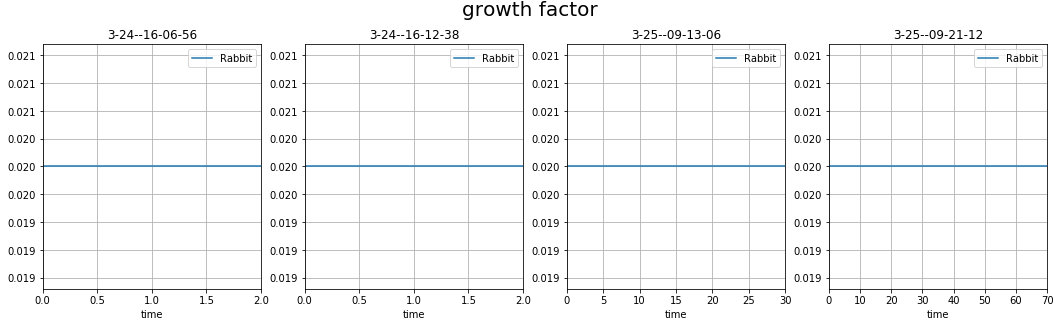

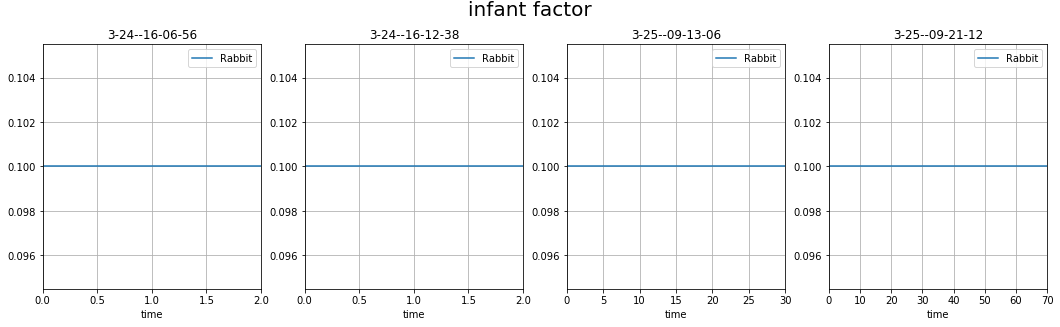

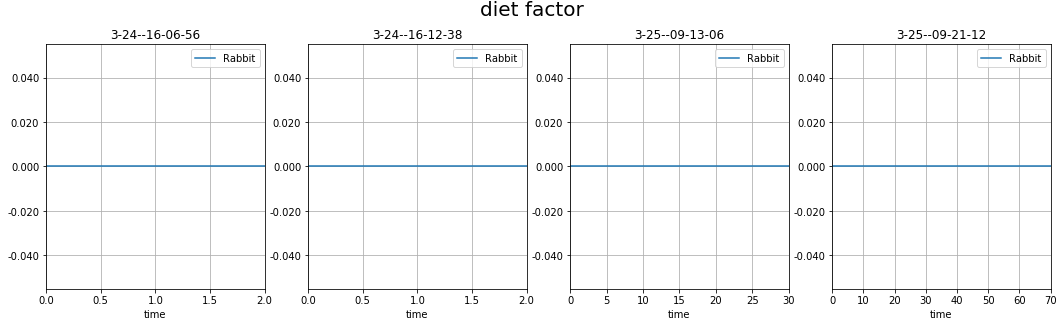

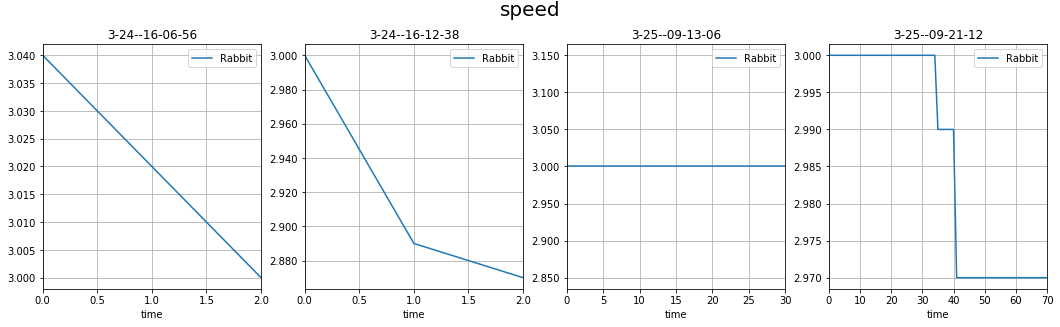

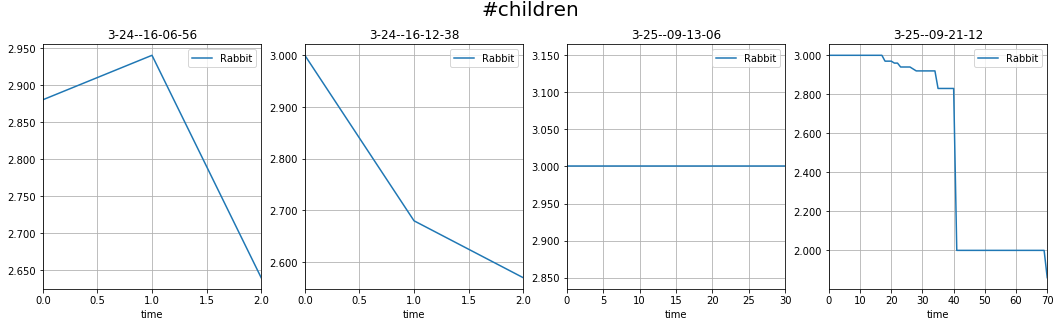

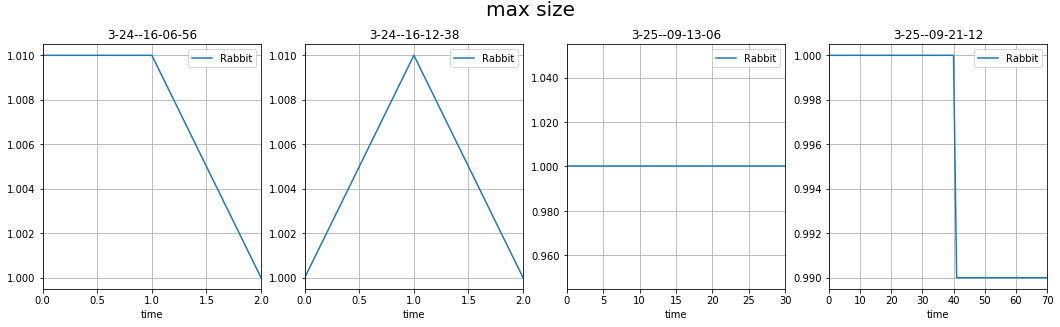

In [9]:
# plot traits grouped by trait and simulation
for t in traits:
    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,4.5))
    fig.get_axes()[0].annotate(t,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for df in dataframes:
        ax = None
        legend = []
        for s in species:
            col = s + '-' + t
            # if e.g Rabbit-speed existed in this simulation, then plot it
            if col in df[0].columns:
                ax = df[0].plot(kind='line', use_index=True, y=col, grid=True, title=df[1], ax=axes[counter])
                legend.append(s)
                ax.set_xlabel("time")
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                counter += 1
        # if the the simulation had this trait, then fix legend name
        if len(legend) > 0:
            ax.legend(legend)
    if export:
        fig.savefig(folder + "/" + t)